In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
import torchaudio.transforms as T
from torchvision.models import resnet50
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')

In [4]:
data_dir = '//kaggle/input/heartbeat-sounds/set_b'
file_csv = '/kaggle/input/heartbeat-sounds/set_b.csv'

In [5]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [6]:
NUM_SAMPLES = 65500
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 10
train_size = 0.8

In [7]:
recordings_old = sorted(os.listdir(data_dir))

In [8]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [9]:
len(recordings)

638

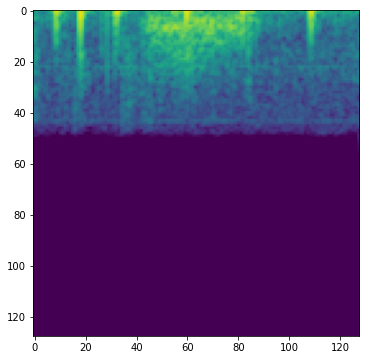

In [10]:
y, _ = librosa.load(data_dir + '/' + recordings[200], sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [11]:
image_size = melspec.shape
image_size

(128, 128)

In [12]:
melspec = torch.tensor(melspec)
melspec = torch.stack([melspec, melspec, melspec])

In [13]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 12):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 12):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 12):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(12)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 12)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [14]:
def get_spectrograms(filename):
    y, _ = librosa.load(filename, sr = sr)
    count = len(y) // NUM_SAMPLES
    mel_spectrograms = []
    for i in range(count):
        samples = y[i * NUM_SAMPLES:(i + 1) * NUM_SAMPLES]
        melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
        melspec = librosa.power_to_db(melspec)
        melspec = normalize(melspec, mean=None, std=None)
        mel_spectrograms.append(torch.tensor(melspec, dtype=torch.float32))

    return mel_spectrograms, count

In [15]:
class HeartbeatSounds(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
data = []
labels = []
for i in range(len(recordings)):
    if 'normal' in recordings[i]:
        label = 0
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'extrastole' in recordings[i]:
        label = 1
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'murmur' in recordings[i]:
        label = 2
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)

In [17]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [18]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [19]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet50

### No Augmentation

In [20]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = False, aug_type = 'No', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch: 0
Train
0.8273576008269861
TEST
loss: 3.649050723938715
accuracy: 0.37777777777777777
******************
epoch: 1
Train
0.6083388596512762
TEST
loss: 32.87420885600741
accuracy: 0.09206349206349207
******************
epoch: 2
Train
0.5539841464438828
TEST
loss: 0.5262290855248769
accuracy: 0.819047619047619
******************
epoch: 3
Train
0.5108131591860883
TEST
loss: 0.6805507921037219
accuracy: 0.8126984126984127
******************
epoch: 4
Train
0.4931864463875841
TEST
loss: 1.22544159681078
accuracy: 0.6158730158730159
******************
epoch: 5
Train
0.4960806757992842
TEST
loss: 0.5994142702647618
accuracy: 0.8
******************
epoch: 6
Train
0.38213746201149335
TEST
loss: 0.8562441244957939
accuracy: 0.6253968253968254
******************
epoch: 7
Train
0.3758158073764268
TEST
loss: 0.6336000601450602
accuracy: 0.7206349206349206
******************
epoch: 8
Train
0.38604434006170585
TEST
loss: 0.7584074744156428
accuracy: 0.7968253968253968
******************
epoch: 9

In [21]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8071065989847716


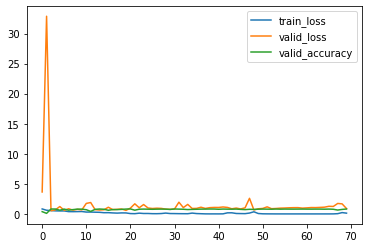

In [22]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [23]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8545663072250493
TEST
loss: 1.5911522051644704
accuracy: 0.765079365079365
******************
epoch: 1
Train
0.6404669486501087
TEST
loss: 0.7574919282443939
accuracy: 0.7555555555555555
******************
epoch: 2
Train
0.597150984669224
TEST
loss: 2.2161426449578907
accuracy: 0.37777777777777777
******************
epoch: 3
Train
0.5961487162103721
TEST
loss: 0.7049048185348511
accuracy: 0.7523809523809524
******************
epoch: 4
Train
0.6032913876394131
TEST
loss: 0.9973277245249067
accuracy: 0.5619047619047619
******************
epoch: 5
Train
0.5230659238869847
TEST
loss: 0.8629547867510053
accuracy: 0.819047619047619
******************
epoch: 6
Train
0.47942393445324766
TEST
loss: 0.6882807470503307
accuracy: 0.819047619047619
******************
epoch: 7
Train
0.44844591111015764
TEST
loss: 0.4373923095445784
accuracy: 0.8380952380952381
******************
epoch: 8
Train
0.4185098888999039
TEST
loss: 0.9828761085631356
accuracy: 0

In [24]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8248730964467005


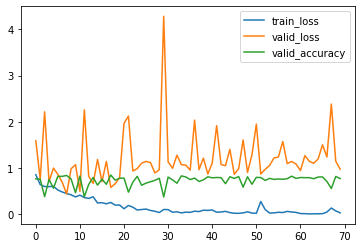

In [25]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [26]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8980747772834905
TEST
loss: 2.162172091574896
accuracy: 0.5492063492063493
******************
epoch: 1
Train
0.598080986804485
TEST
loss: 1.536127137380933
accuracy: 0.6730158730158731
******************
epoch: 2
Train
0.5458493452397862
TEST
loss: 2.3370854120405893
accuracy: 0.4634920634920635
******************
epoch: 3
Train
0.5575577771029272
TEST
loss: 0.520660493582014
accuracy: 0.8095238095238095
******************
epoch: 4
Train
0.5105177125730053
TEST
loss: 0.6801475984709603
accuracy: 0.7873015873015873
******************
epoch: 5
Train
0.4331552590094832
TEST
loss: 0.4774009391428932
accuracy: 0.8222222222222222
******************
epoch: 6
Train
0.42765588311565783
TEST
loss: 0.5502613277662368
accuracy: 0.7904761904761904
******************
epoch: 7
Train
0.39993617220280947
TEST
loss: 0.8430504214195979
accuracy: 0.6857142857142857
******************
epoch: 8
Train
0.39522540685295393
TEST
loss: 0.5682816503539918
accuracy: 0

In [27]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8248730964467005


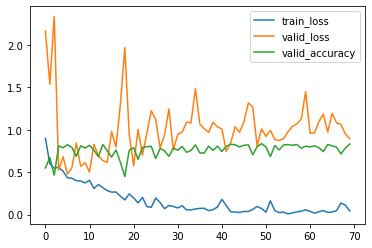

In [28]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [29]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8032243992242669
TEST
loss: 1.0299010454662263
accuracy: 0.6793650793650794
******************
epoch: 1
Train
0.5775388616527045
TEST
loss: 0.5643329788768102
accuracy: 0.819047619047619
******************
epoch: 2
Train
0.46618748747989996
TEST
loss: 0.5525088507031638
accuracy: 0.8095238095238095
******************
epoch: 3
Train
0.5071733496177755
TEST
loss: 0.532128177559565
accuracy: 0.8095238095238095
******************
epoch: 4
Train
0.44104620993042676
TEST
loss: 2.6781790634942433
accuracy: 0.32063492063492066
******************
epoch: 5
Train
0.45100432104113747
TEST
loss: 1.7558725243523008
accuracy: 0.4380952380952381
******************
epoch: 6
Train
0.3508849889395065
TEST
loss: 0.948683256005484
accuracy: 0.6793650793650794
******************
epoch: 7
Train
0.31791906445816076
TEST
loss: 0.6193467265083676
accuracy: 0.7777777777777778
******************
epoch: 8
Train
0.3485803098504367
TEST
loss: 0.6768767247124324
accuracy

In [30]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8045685279187818


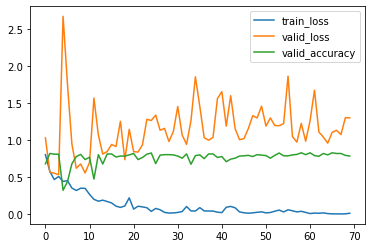

In [31]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [32]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.7924578712041459
TEST
loss: 1.8860474221290104
accuracy: 0.765079365079365
******************
epoch: 1
Train
0.6021519484171515
TEST
loss: 0.6525634165794131
accuracy: 0.7682539682539683
******************
epoch: 2
Train
0.5587485371079115
TEST
loss: 0.5030732648713249
accuracy: 0.8158730158730159
******************
epoch: 3
Train
0.4911833897031802
TEST
loss: 0.5587307765370324
accuracy: 0.8031746031746032
******************
epoch: 4
Train
0.4821487910412341
TEST
loss: 0.7679641307346404
accuracy: 0.6825396825396826
******************
epoch: 5
Train
0.4794229438988532
TEST
loss: 3.2310098496694413
accuracy: 0.7047619047619048
******************
epoch: 6
Train
0.4424589621916567
TEST
loss: 1.9224856085247464
accuracy: 0.45396825396825397
******************
epoch: 7
Train
0.41857895264557377
TEST
loss: 0.6759437154209803
accuracy: 0.7777777777777778
******************
epoch: 8
Train
0.3679963429832004
TEST
loss: 0.6026756570452736
accuracy:

In [33]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8223350253807107


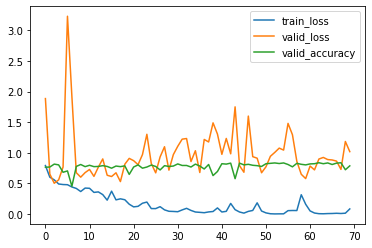

In [34]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [35]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8536566943285293
TEST
loss: 1.5404932498931885
accuracy: 0.6698412698412698
******************
epoch: 1
Train
0.6832040107562677
TEST
loss: 0.7831782195303175
accuracy: 0.726984126984127
******************
epoch: 2
Train
0.6023910074502916
TEST
loss: 0.5778627909365155
accuracy: 0.7968253968253968
******************
epoch: 3
Train
0.5852323735015936
TEST
loss: 1.2097942452582102
accuracy: 0.780952380952381
******************
epoch: 4
Train
0.5912811734829752
TEST
loss: 0.6087498464281597
accuracy: 0.8158730158730159
******************
epoch: 5
Train
0.6315184053776282
TEST
loss: 1.4904893178788443
accuracy: 0.42857142857142855
******************
epoch: 6
Train
0.6173134992480562
TEST
loss: 0.5647988868138146
accuracy: 0.7873015873015873
******************
epoch: 7
Train
0.5535060921010752
TEST
loss: 0.47803449195528785
accuracy: 0.8222222222222222
******************
epoch: 8
Train
0.5243035412857322
TEST
loss: 0.5409785433421059
accuracy: 

In [36]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8350253807106599


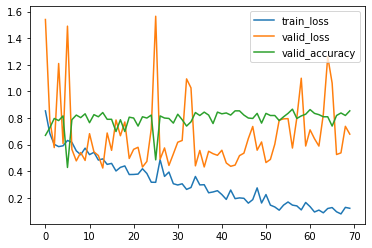

In [37]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [38]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.9803015522960635
TEST
loss: 2.1603230635325112
accuracy: 0.23174603174603176
******************
epoch: 1
Train
0.8175169347864565
TEST
loss: 6.9092345146905805
accuracy: 0.2507936507936508
******************
epoch: 2
Train
0.7228371674717182
TEST
loss: 0.6079071302262563
accuracy: 0.7777777777777778
******************
epoch: 3
Train
0.6434816389542141
TEST
loss: 0.6234436023802984
accuracy: 0.7714285714285715
******************
epoch: 4
Train
0.7014113803341618
TEST
loss: 0.600596925568959
accuracy: 0.7968253968253968
******************
epoch: 5
Train
0.6479523628831761
TEST
loss: 15.960725766136532
accuracy: 0.2507936507936508
******************
epoch: 6
Train
0.6675087752751266
TEST
loss: 0.9051282680223859
accuracy: 0.6031746031746031
******************
epoch: 7
Train
0.6240546406972399
TEST
loss: 0.5673871437708536
accuracy: 0.7873015873015873
******************
epoch: 8
Train
0.5894266967265922
TEST
loss: 0.5859063360426161
accuracy: 

In [39]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8045685279187818


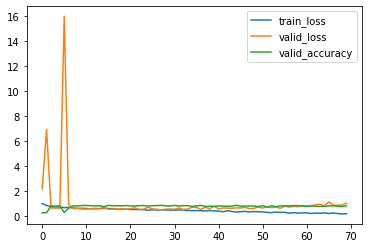

In [40]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [41]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.9903540478707117
TEST
loss: 20.30245069473509
accuracy: 0.09206349206349207
******************
epoch: 1
Train
0.7957012255670912
TEST
loss: 2.674051975068592
accuracy: 0.3873015873015873
******************
epoch: 2
Train
0.7095665631548008
TEST
loss: 2.3139663234589594
accuracy: 0.6793650793650794
******************
epoch: 3
Train
0.6831806590861986
TEST
loss: 1.1359894370275831
accuracy: 0.6793650793650794
******************
epoch: 4
Train
0.6701937492543312
TEST
loss: 1.3876264564574712
accuracy: 0.6952380952380952
******************
epoch: 5
Train
0.6619949968113039
TEST
loss: 1.9400731499232944
accuracy: 0.6412698412698413
******************
epoch: 6
Train
0.6109461511194564
TEST
loss: 0.9716955010853117
accuracy: 0.5841269841269842
******************
epoch: 7
Train
0.5851766671615521
TEST
loss: 0.9566354407204523
accuracy: 0.765079365079365
******************
epoch: 8
Train
0.5575102546841877
TEST
loss: 1.3537178232556297
accuracy: 0.

In [42]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8147208121827412


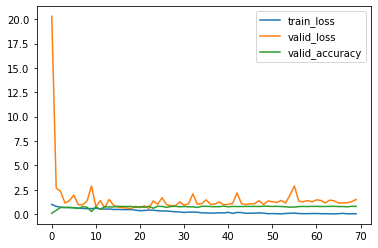

In [43]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [44]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8270231614139366
TEST
loss: 1.908781830091325
accuracy: 0.3492063492063492
******************
epoch: 1
Train
0.6260653711009159
TEST
loss: 2.605301626901778
accuracy: 0.7396825396825397
******************
epoch: 2
Train
0.5787921483976866
TEST
loss: 0.5109928365737673
accuracy: 0.834920634920635
******************
epoch: 3
Train
0.5142523996218317
TEST
loss: 0.5400748122306097
accuracy: 0.8285714285714286
******************
epoch: 4
Train
0.5047208235981542
TEST
loss: 0.5828994173852224
accuracy: 0.7587301587301587
******************
epoch: 5
Train
0.45751937142054744
TEST
loss: 0.6403227281948877
accuracy: 0.7619047619047619
******************
epoch: 6
Train
0.4346178591109345
TEST
loss: 0.9837966807304867
accuracy: 0.5238095238095238
******************
epoch: 7
Train
0.4356128412451983
TEST
loss: 0.663016332520379
accuracy: 0.8
******************
epoch: 8
Train
0.37891540044920136
TEST
loss: 0.9451557210513524
accuracy: 0.742857142857142

In [45]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8197969543147208


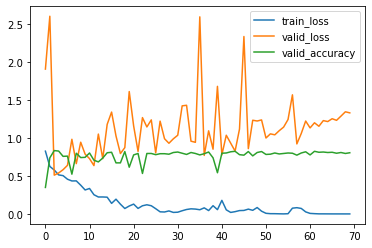

In [46]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [47]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.858683449205091
TEST
loss: 1.846580566300286
accuracy: 0.7777777777777778
******************
epoch: 1
Train
0.6582019169999078
TEST
loss: 1.665556886839488
accuracy: 0.7968253968253968
******************
epoch: 2
Train
0.5915348848551394
TEST
loss: 1.1262630544011556
accuracy: 0.8063492063492064
******************
epoch: 3
Train
0.5185858734644434
TEST
loss: 0.8193242033322652
accuracy: 0.6571428571428571
******************
epoch: 4
Train
0.4766041131318799
TEST
loss: 0.463970232577551
accuracy: 0.819047619047619
******************
epoch: 5
Train
0.4856290396974615
TEST
loss: 0.9214495053367009
accuracy: 0.6507936507936508
******************
epoch: 6
Train
0.4234075784872599
TEST
loss: 1.6986064967655001
accuracy: 0.5301587301587302
******************
epoch: 7
Train
0.4484303990842048
TEST
loss: 0.5592811981836955
accuracy: 0.7777777777777778
******************
epoch: 8
Train
0.3977018038345008
TEST
loss: 0.5221985391208104
accuracy: 0.8
*

In [48]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8324873096446701


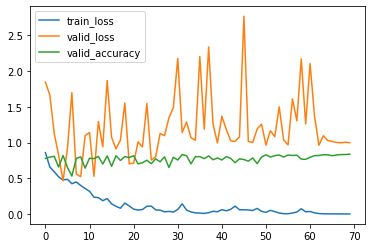

In [49]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [50]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8323582235643843
TEST
loss: 2.4623566112821065
accuracy: 0.7523809523809524
******************
epoch: 1
Train
0.6536755903170542
TEST
loss: 0.5530122987807743
accuracy: 0.7968253968253968
******************
epoch: 2
Train
0.5819900009819589
TEST
loss: 0.5929734004868401
accuracy: 0.765079365079365
******************
epoch: 3
Train
0.5955356206801129
TEST
loss: 0.763653694637238
accuracy: 0.7587301587301587
******************
epoch: 4
Train
0.5715040118093998
TEST
loss: 0.9402023014568147
accuracy: 0.6507936507936508
******************
epoch: 5
Train
0.5737560543396626
TEST
loss: 1.2694035823383027
accuracy: 0.6063492063492063
******************
epoch: 6
Train
0.5347609621745618
TEST
loss: 0.7679672263917469
accuracy: 0.6761904761904762
******************
epoch: 7
Train
0.5122624092200524
TEST
loss: 0.5117688669098748
accuracy: 0.8031746031746032
******************
epoch: 8
Train
0.49710422153033557
TEST
loss: 0.5390931677250635
accuracy: 0

In [51]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8934010152284264


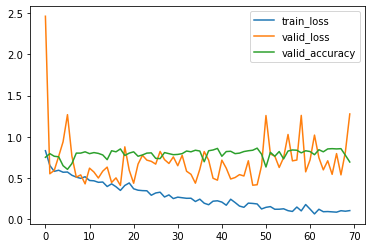

In [52]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [53]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.9568294919228345
TEST
loss: 4.457492284926158
accuracy: 0.6761904761904762
******************
epoch: 1
Train
0.7381667093779948
TEST
loss: 0.9164619691788204
accuracy: 0.7714285714285715
******************
epoch: 2
Train
0.6828146955150759
TEST
loss: 0.9410136419629294
accuracy: 0.7428571428571429
******************
epoch: 3
Train
0.6352760957005101
TEST
loss: 0.5860728097340417
accuracy: 0.780952380952381
******************
epoch: 4
Train
0.6209353979283424
TEST
loss: 0.6598916511687022
accuracy: 0.765079365079365
******************
epoch: 5
Train
0.6401371729099343
TEST
loss: 0.6095912619242593
accuracy: 0.7555555555555555
******************
epoch: 6
Train
0.6110309502546327
TEST
loss: 0.6451566300694904
accuracy: 0.7523809523809524
******************
epoch: 7
Train
0.6404229745541044
TEST
loss: 0.5507599136186024
accuracy: 0.7968253968253968
******************
epoch: 8
Train
0.5716009904601632
TEST
loss: 0.5347227067228347
accuracy: 0.8

In [54]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.7918781725888325


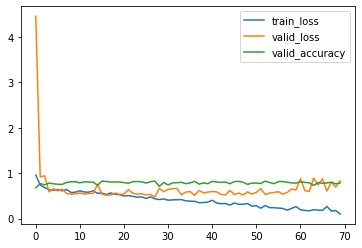

In [55]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [56]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8674574619346994
TEST
loss: 1.0051251604443505
accuracy: 0.6634920634920635
******************
epoch: 1
Train
0.7129469378019155
TEST
loss: 0.6433935874984378
accuracy: 0.7714285714285715
******************
epoch: 2
Train
0.6357517914700073
TEST
loss: 0.553922364446852
accuracy: 0.8158730158730159
******************
epoch: 3
Train
0.5752676652716303
TEST
loss: 0.5352953023380703
accuracy: 0.8031746031746032
******************
epoch: 4
Train
0.558320520604007
TEST
loss: 0.6120932252634139
accuracy: 0.8031746031746032
******************
epoch: 5
Train
0.5465654309445472
TEST
loss: 0.5651081172246781
accuracy: 0.7936507936507936
******************
epoch: 6
Train
0.5013457999947148
TEST
loss: 0.49870737176092844
accuracy: 0.8285714285714286
******************
epoch: 7
Train
0.4618854042411892
TEST
loss: 0.5970735340837449
accuracy: 0.7841269841269841
******************
epoch: 8
Train
0.49118869138010157
TEST
loss: 1.1306051844642275
accuracy: 

In [57]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8578680203045685


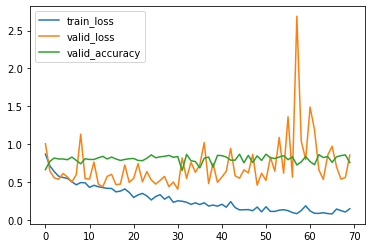

In [58]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [59]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
1.0009265588426324
TEST
loss: 0.8239605810907152
accuracy: 0.6761904761904762
******************
epoch: 1
Train
0.7973694324114665
TEST
loss: 0.9192731917850555
accuracy: 0.7365079365079366
******************
epoch: 2
Train
0.7410626526007679
TEST
loss: 0.7515176937693642
accuracy: 0.7206349206349206
******************
epoch: 3
Train
0.7151553030994982
TEST
loss: 0.6240047761372157
accuracy: 0.7587301587301587
******************
epoch: 4
Train
0.6442140990822347
TEST
loss: 0.6101032279786609
accuracy: 0.780952380952381
******************
epoch: 5
Train
0.6260465839441283
TEST
loss: 1.4306495219942124
accuracy: 0.26031746031746034
******************
epoch: 6
Train
0.5793900204329759
TEST
loss: 0.559040457672543
accuracy: 0.819047619047619
******************
epoch: 7
Train
0.6165810437359632
TEST
loss: 0.5341403194836207
accuracy: 0.7968253968253968
******************
epoch: 8
Train
0.5521588784726107
TEST
loss: 0.5637508492621165
accuracy: 0.

In [60]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8274111675126904


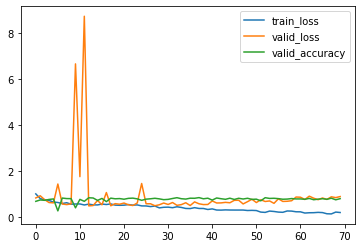

In [61]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [62]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8258944004774094
TEST
loss: 4.364814463115874
accuracy: 0.473015873015873
******************
epoch: 1
Train
0.6374229776471072
TEST
loss: 0.962891533828917
accuracy: 0.6222222222222222
******************
epoch: 2
Train
0.5401644225722746
TEST
loss: 0.5897720607500228
accuracy: 0.819047619047619
******************
epoch: 3
Train
0.5554156465081586
TEST
loss: 0.9699770794974433
accuracy: 0.7968253968253968
******************
epoch: 4
Train
0.5000519838666424
TEST
loss: 0.6648592882686191
accuracy: 0.7841269841269841
******************
epoch: 5
Train
0.5018545504691962
TEST
loss: 0.5283971563218132
accuracy: 0.819047619047619
******************
epoch: 6
Train
0.4802721206681704
TEST
loss: 0.997966958984496
accuracy: 0.6063492063492063
******************
epoch: 7
Train
0.4632467244995123
TEST
loss: 0.5285673114988539
accuracy: 0.8031746031746032
******************
epoch: 8
Train
0.4408974287716333
TEST
loss: 0.5239461077584161
accuracy: 0.8095

In [63]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8401015228426396


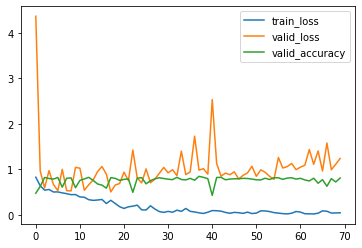

In [64]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [65]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8394900976049228
TEST
loss: 1.1603324401946296
accuracy: 0.7746031746031746
******************
epoch: 1
Train
0.5841829265461165
TEST
loss: 0.5486201089525979
accuracy: 0.819047619047619
******************
epoch: 2
Train
0.5422955894867895
TEST
loss: 0.535669242484229
accuracy: 0.8126984126984127
******************
epoch: 3
Train
0.502570601850393
TEST
loss: 0.49354766380219234
accuracy: 0.834920634920635
******************
epoch: 4
Train
0.43891447957685015
TEST
loss: 0.6862922693055774
accuracy: 0.8095238095238095
******************
epoch: 5
Train
0.5083803906149102
TEST
loss: 0.9718883626044743
accuracy: 0.6698412698412698
******************
epoch: 6
Train
0.4188899746293393
TEST
loss: 0.6832252799518524
accuracy: 0.7777777777777778
******************
epoch: 7
Train
0.38725999369329644
TEST
loss: 0.8436144383180709
accuracy: 0.6158730158730159
******************
epoch: 8
Train
0.4259146114869
TEST
loss: 1.2172630453866626
accuracy: 0.78

In [66]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8248730964467005


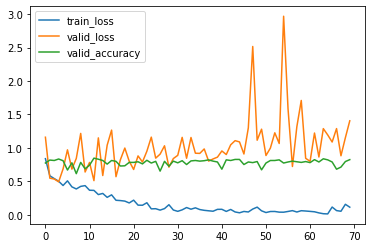

In [67]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [68]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8783758137318897
TEST
loss: 0.609975376583281
accuracy: 0.7746031746031746
******************
epoch: 1
Train
0.6074965269059961
TEST
loss: 1.1050075069306389
accuracy: 0.7238095238095238
******************
epoch: 2
Train
0.5744646057143299
TEST
loss: 0.4555019621811216
accuracy: 0.8380952380952381
******************
epoch: 3
Train
0.49290003772526153
TEST
loss: 0.4736719440846216
accuracy: 0.819047619047619
******************
epoch: 4
Train
0.47575660164721717
TEST
loss: 0.7389036662994869
accuracy: 0.7777777777777778
******************
epoch: 5
Train
0.5313330607531656
TEST
loss: 0.7206777014429607
accuracy: 0.8126984126984127
******************
epoch: 6
Train
0.4066524703981765
TEST
loss: 0.5865107674447317
accuracy: 0.7365079365079366
******************
epoch: 7
Train
0.3803592208266921
TEST
loss: 0.5042879369523791
accuracy: 0.8031746031746032
******************
epoch: 8
Train
0.37643114738373457
TEST
loss: 0.690369745284792
accuracy: 

In [69]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8121827411167513


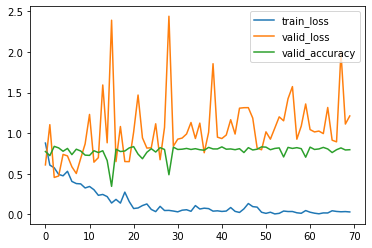

In [70]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [71]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.767124648459664
TEST
loss: 1.3110152166987223
accuracy: 0.7238095238095238
******************
epoch: 1
Train
0.5999354648154533
TEST
loss: 1.4855426705072796
accuracy: 0.6793650793650794
******************
epoch: 2
Train
0.56215824429434
TEST
loss: 0.5636225909467727
accuracy: 0.8126984126984127
******************
epoch: 3
Train
0.48820514878741894
TEST
loss: 0.6314642558022151
accuracy: 0.7682539682539683
******************
epoch: 4
Train
0.47491183235495693
TEST
loss: 0.5083841332367488
accuracy: 0.8031746031746032
******************
epoch: 5
Train
0.5308293953975862
TEST
loss: 1.5781058985089498
accuracy: 0.6984126984126984
******************
epoch: 6
Train
0.48533650226683916
TEST
loss: 0.7104826210037111
accuracy: 0.692063492063492
******************
epoch: 7
Train
0.44806235327997124
TEST
loss: 0.7122209512998188
accuracy: 0.6698412698412698
******************
epoch: 8
Train
0.3897756583355456
TEST
loss: 0.7975287293630933
accuracy: 

In [72]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8197969543147208


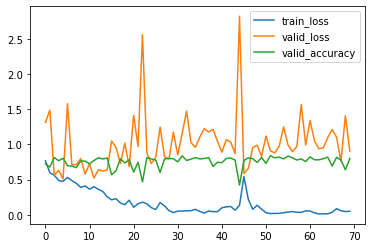

In [73]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [74]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8292409911621554
TEST
loss: 3.804368780529688
accuracy: 0.45396825396825397
******************
epoch: 1
Train
0.6659851285367849
TEST
loss: 1.338323712348938
accuracy: 0.39365079365079364
******************
epoch: 2
Train
0.5788442583856742
TEST
loss: 0.5706953831135281
accuracy: 0.765079365079365
******************
epoch: 3
Train
0.5341127417549622
TEST
loss: 0.49981842400535703
accuracy: 0.8063492063492064
******************
epoch: 4
Train
0.4987401453344665
TEST
loss: 1.908605764593397
accuracy: 0.6444444444444445
******************
epoch: 5
Train
0.5378156465325117
TEST
loss: 0.8243076560989259
accuracy: 0.7682539682539683
******************
epoch: 6
Train
0.4855001200940327
TEST
loss: 0.5330812611277141
accuracy: 0.834920634920635
******************
epoch: 7
Train
0.45044104775045485
TEST
loss: 0.6724249960884215
accuracy: 0.7777777777777778
******************
epoch: 8
Train
0.44487267320737467
TEST
loss: 0.6224715798620194
accuracy: 

In [75]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8350253807106599


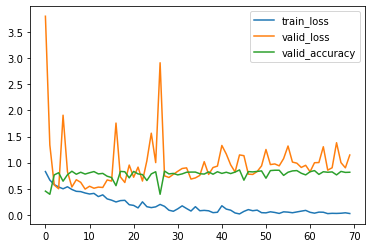

In [76]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [77]:
seed_everything(random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 70
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 10
epoch: 0
Train
0.8346910317139175
TEST
loss: 0.9616910955262563
accuracy: 0.6698412698412698
******************
epoch: 1
Train
0.632643575939136
TEST
loss: 0.6369096246976701
accuracy: 0.7777777777777778
******************
epoch: 2
Train
0.6090637437401545
TEST
loss: 0.5869334135736738
accuracy: 0.7841269841269841
******************
epoch: 3
Train
0.5509871010320162
TEST
loss: 0.7382118321600415
accuracy: 0.7746031746031746
******************
epoch: 4
Train
0.5395496774988576
TEST
loss: 0.5890911601838611
accuracy: 0.7777777777777778
******************
epoch: 5
Train
0.5206586222642939
TEST
loss: 0.7103598708198184
accuracy: 0.726984126984127
******************
epoch: 6
Train
0.4879898009932732
TEST
loss: 0.7580797148129297
accuracy: 0.7904761904761904
******************
epoch: 7
Train
0.4418582907738053
TEST
loss: 0.6261226389143202
accuracy: 0.7587301587301587
******************
epoch: 8
Train
0.426053921223823
TEST
loss: 0.78313670290841
accuracy: 0.777

In [78]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.8324873096446701


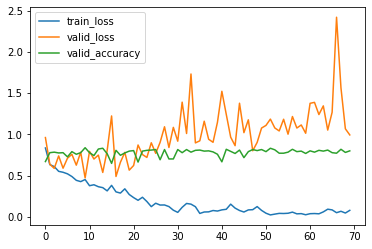

In [79]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()